<a href="https://colab.research.google.com/github/fedhere/DSPS_FBianco/blob/main/HW4/MWrotCurve_instructions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Template prepared by federica b bianco @fedhere

Completed by Christian Munley for UDel DSPS PHYS 461/661

# testing the "significance" of Dark Matter

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pylab as pl

# constants and units conversion
import astropy
from astropy.constants import G
from astropy import units as u

# latex
from IPython.display import Latex



In 1970 Vera Rubin published a seminal paper: she measured the rotational speed of HII regions in several galaxies and how it changed as a function of distance to the center of the galaxy. If we believe Newtonian gravity (or GR) we expect that _once all of the mass is included_, i.e. at a radius distance from the center of the galaxy larger than the radius of the galaxy itself, the rotational speed will be proportional to $v\propto\frac{1}{\sqrt{r}}$

## Propagation of  uncertainties rules

below are the basic rules for propagation of uncertainties - [reference](https://github.com/fedhere/DSPS/blob/master/resources/Managing%20Errors%20and%20Uncertainty.pdf)




$$
\begin{eqnarray}
z = x  \pm y  ~| & ~  &dz = \sqrt{dx^2 + dy^2}
\\
z = x * y  ~| & ~& dz = |xy|  \sqrt{\left(\frac{dx}{x}\right)^2 +
                                \left(\frac{dy}{y}\right)^2} \\
z = x / y  ~| & ~& dz = \left|\frac{x}{y}\right| \sqrt{\left(\frac{dx}{x}\right)^2 +
                                                   \left(\frac{dy}{y}\right)^2} \\
z = x^n ~| & ~& dz = |n| ~ x^{n-1}  dx \\
z = \mathrm{c}x ~| & ~& dz = |\mathrm{c}| ~dx \\
z = f(x, y) ~| & ~& dz = \sqrt{\left(\frac{\partial f}{\partial x}\right)^2 dx^2 +\left(\frac{\partial f}{\partial y}\right)^2 dy^2} \\
\end{eqnarray}
$$


# let's assume a Newtonian framework:
the velocity of a body in orbit depends only on the gravitational field of the mass that attracts it, and we can assume that mass is concentrated in the center of mass of (the center for simplicity) the system

with G the gravitational constant, $r$ the radius, and $m(r)$ the mass contained within that radius we have the orbital velocity $v$:



$v^2 = \frac{G \cdot m(r)}{r}$


Derivation:

The orbital speed is $v = \frac{2\pi r}{t} $

Therefore the orbital acceleration is $a = dv/dt = \frac{v^2}{r}$

The gravitational force is $F = \frac{GMm}{r^2}$

Now Newton's 2nd Law

$F = ma$

$ \frac{GMm}{r^2} = m\frac{v^2}{r}$


Now divide both sides by m, and multiply both sides by r:

$v^2 = \frac{G M}{r}$

In the paper, they use m for M, so we are done.


$v^2 = \frac{G m}{r}$


## M31 rotational curve

### data ingestion
M31, the Andromeda galaxy, Vera Rubin's original target.

Note that the data contains 2 types of uncertainties: one significantly smaller than the other. The ```dv``` uncertainty is the propagation of the uncertainty in the location of the HII line. The uncertainty called ```err``` if the full error budget:  including _all_ sources of uncertainty and not just the uncertainty in measuring the location of the line. We will test our hypothesis with each one to see if it matters which uncertainty we choose

In [4]:
m31 = pd.read_csv('m31.csv', skiprows=2, names=["r",'v','dv','err'])

In [5]:
m31.head()

,r,v,dv,err
0,0.100,183.939,0.000,0.000
1,0.120,190.710,10.265,12.191
2,0.144,204.141,22.634,21.808
3,0.173,207.601,4.573,4.200
4,0.207,210.188,3.943,3.258


# exploratory data analysis

In [6]:
m31.shape

(55, 4)

In [7]:
m31.describe()

,r,v,dv,err
count,55.000000,55.000000,55.000000,55.000000
mean,205.853182,226.079255,55.034818,16.165855
std,415.523904,42.799892,49.254792,14.876951
min,0.100000,121.974000,0.000000,0.000000
25%,1.177000,208.894500,11.945500,3.224000
50%,13.737000,229.124000,30.697000,12.065000
75%,161.675000,244.102500,99.980000,23.641000
max,1887.071000,414.942000,147.835000,54.110000


In [8]:
m31.head()

,r,v,dv,err
0,0.100,183.939,0.000,0.000
1,0.120,190.710,10.265,12.191
2,0.144,204.141,22.634,21.808
3,0.173,207.601,4.573,4.200
4,0.207,210.188,3.943,3.258


from https://en.wikipedia.org/wiki/Andromeda_Galaxy get the extent of the luminous component of M31 (Andromeda). The distance of the Galaxy multiplied by the angular size will give you this information from basic trigonometry (make sure you convert the units properly, using astropy). Make sure you include the uncertainties! uncertainties in the distance will give you the uncertainty in the size
   


In [13]:
apparentSizeM31 = 3.167 / 2  * u.degree

In [14]:
m31angS = apparentSizeM31
print("Angular Size of the visible component of Andromeda: {:.2f}".format(m31angS.to(u.rad)  ))

Angular Size of the visible component of Andromeda: 0.03 rad


In [15]:
m31Size = 778 * u.kpc * m31angS.to(u.rad)
m31SizeError = 33 * u.kpc * m31angS.to(u.rad)
print("Size of the visible component of Andromeda: " +
      r"{:.0f} +/- {:2.1f}".format(m31Size, m31SizeError))#, m31SizeError

Size of the visible component of Andromeda: 22 kpc rad +/- 0.9 kpc rad


### first measurement  in data table that includes all the luminous mass:

In [16]:
x = m31[m31.r > m31Size].r.values[0] * u.kpc
print("First measurement outside of the visible radius:", x)

First measurement outside of the visible radius: 23.738 kpc


The function below

1. finds the smallest radius in the dataset that is at least N times the radius of the visible galaxy,

2. takes as arguments:
    - the data and
    - N
    - the size of the luminous component of the galaxy

2. Returns the value of the radius and its uncertainty and the velocity and its uncertainty

In [17]:
def getradii(galaxy, galaxySize, n):
  """
  Retrieve the first row where radial distance 'r' exceeds n * galaxySize.

  Parameters:
  -----------
  galaxy : pd.DataFrame
      Dataframe with a column 'r' for radial distances.
  galaxySize : float
      A characteristic size of the galaxy.
  n : float
      A scalar to scale the galaxySize.

  Returns:
  --------
  r : pd.DataFrame
      A single-row DataFrame where 'r' first exceeds n * galaxySize.
  """
  x = galaxy[galaxy.r > n * galaxySize].r.index[0]
  r = galaxy.iloc[x:x+1]
  return r

### data visualization

The code below creates a plot that shows:
1. the rotational curve of the galaxy (as a line)
2. each velocity as an errorbar with error equal to err in the same color as the line in 1
3. each velocity as an errorbar with error equal to dv in  the same color but a different line thickness
4. the datapoint corresponding to N=1, 2, 3 each in a different color.
5. a legend that indicates the meaning of each color (```pl.legend()```)
6. a text that indicates the velocity and its uncertainty (dv and err) just below the largest errorbar (```pl.text()```)
7. x axis limited to the "relevant" portion of the data

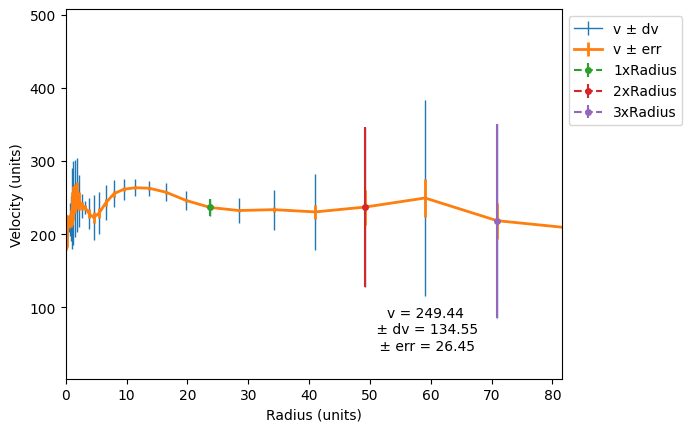

In [18]:
def plotGal(galaxy, radii):
    """
    Plot the rotation curve of a galaxy with error bars and specific radial data points.

    Parameters:
    -----------
    galaxy : pd.DataFrame
        Dataframe containing radial ('r'), velocity ('v'), and error values ('dv', 'err').
    radii : tuple of pd.DataFrame
        Tuple containing DataFrames with 'r' and 'v' values for specific radial points (e.g., 1x, 2x, 3x galaxy size).

    Notes:
    ------
    The function plots 'v' and two types of error bars ('dv' and 'err') for the entire galaxy dataset.
    It also plots 'v' values for specified radial points with error bars ('dv').
    Additional annotations and legend are added to enhance the plot readability.

    Ensure matplotlib is imported and your runtime is configured to display plots.
    """
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Set x-axis limit
    ax.set_xlim(0, radii[2]['r'].values[0] * 1.15)

    # Plot rotation curve (v) and error bars (dv, err) with labels
    ax.errorbar(galaxy['r'], galaxy['v'], yerr=galaxy['dv'], linewidth=1, label="v ± dv")
    ax.errorbar(galaxy['r'], galaxy['v'], yerr=galaxy['err'], linewidth=2, label="v ± err")

    # Add colored error bars for N=1, 2, 3 with labels
    ax.errorbar(radii[0]['r'], radii[0]['v'], yerr=radii[0]['dv'], label="1xRadius", fmt='--o', markersize=4)
    ax.errorbar(radii[1]['r'], radii[1]['v'], yerr=radii[1]['dv'], label="2xRadius", fmt='--o', markersize=4)
    ax.errorbar(radii[2]['r'], radii[2]['v'], yerr=radii[2]['dv'], label="3xRadius", fmt='--o', markersize=4)

    # Find the largest error bar within the x-axis range
    x_lim = ax.get_xlim()
    valid_errors = galaxy[(galaxy['r'] >= x_lim[0]) & (galaxy['r'] <= x_lim[1])]
    largest_err = max(max(valid_errors['dv']), max(valid_errors['err']))

    # Find the index of the largest error bar
    largest_err_idx = valid_errors['dv'].idxmax() if max(valid_errors['dv']) > max(valid_errors['err']) else valid_errors['err'].idxmax()

    # Add text below the largest error bar
    ax.text(valid_errors['r'][largest_err_idx], valid_errors['v'][largest_err_idx] - largest_err - 45,
            f"v = {valid_errors['v'][largest_err_idx]:.2f}\n ± dv = {valid_errors['dv'][largest_err_idx]:.2f}\n ± err = {valid_errors['err'][largest_err_idx]:.2f}",
            ha='center', va='center')

     # Add labels to axes
    ax.set_xlabel('Radius (units)')
    ax.set_ylabel('Velocity (units)')

    ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Construct radii to compare against
m31Rds = (getradii(m31, m31Size, 1),
          getradii(m31, m31Size, 2),
          getradii(m31, m31Size, 3))

# Call plot function
plotGal(m31, m31Rds)

plt.show()


### Figure 1: Rotation curve of M31 galaxy with error bars for velocity (v) and two different uncertainties (dv and err). Colored error bars represent different radii multiples. This plot shows how the relative speed of the galaxy with respect to its center changes as a function of the radius. The purpose is to demonstrate that it does not follow the newtonian prediction exactly, thus suggesting dark matter. We analyze the newtonian prediction vs the measurements below with uncertainy considerations, and find the predictions are only consistent with measurements when we use the first error, dv.



The function below takes a dataset and a luminous radius and a number N, and:
  
  1) uses the function above to find the radius at least as large as needed and the velocity at that radius,
  
  2) states the expected drop in rotational velocities according to Newton's law $v\propto 1/\sqrt{r}$
  
  3) calculates the ratio of radii and the ratio of velocities at N radii from the center N=1 and N=N (input, e.g. 2, 3 etc) with uncertainties,
  
  4) and stated whether that ratio is consistent within the uncertainties with Newton's law $v \propto 1/\sqrt{r}$

The function prints:

     - the expected ratio based on the radii,
     - the calculated ratio using ```dv```, and its uncertainty, -
     - the 2-$\sigma$ upper and lower limits of the calculated ratio
     - whether the expected ratio is within the $2-\sigma$ of the calculated ratio,
  5) and the same using ```err```  instead of ```dv```

In [19]:
def vratios(galaxy, radii, radius, err='dv'):
    """
    Analyze the velocity ratios for a galaxy given the data for radii and a specified radius.

    Parameters:
    galaxy (DataFrame): A dataframe containing the data of the galaxy, expecting columns ['v', err, 'r'].
    radii (list[DataFrame]): A list of dataframes containing the data for the radii of the galaxy.
    radius (int): An integer representing the radius at which to perform the analysis.
    N (int): The desired radius index to calculate ratio of radii and velocities.
    err (str): A string indicating the type of error to be used in the analysis ('dv' or other error types in the dataset).

    The function will print the following information:
        - Expected and actual velocity ratios with their uncertainties.
        - Expected and calculated 2-sigma upper and lower limits.
        - Consistency check within 2-sigma significance.
    For both error types: 'dv' and the specified error type `err`.
    """
    r1 = radii[0]
    rN = radii[radius - 1]
    rerr = 0.9

    # Actual ratio (input radius vs. 1x)
    vratio = r1["v"].values[0] / rN["v"].values[0]

    # Uncertainty propagation for vratio
    vratio_error = vratio * np.sqrt(
        (rN[err].values[0] / rN["v"].values[0])**2 +
        (r1[err].values[0] / r1["v"].values[0])**2)

    # Expected ratio and error propagation
    r_ratio = rN.r.values[0] / r1.r.values[0]
    exp_ratio = np.sqrt(r_ratio)

    r_ratio_error = r_ratio * np.sqrt(
    (rN.r.values[0]/rerr)**2 + (r1.r.values[0]/rerr)**2)

    exp_ratio_error = 0.5 * (r_ratio_error)**(0.5-1)

    print('-' * 20)
    print(f"Error type: {err}")
    print(f"Radius value: {radius}x")
    print(f"Expected velocity ratio: {exp_ratio:.2f} +/- {exp_ratio_error:.2f}")
    print(f"Actual velocity ratio: {vratio:.2f} +/- {vratio_error:.2f}")
    sigma = 2

    ubound = vratio + vratio_error * sigma
    lbound = vratio - vratio_error * sigma
    print(f'Expected range: {round(exp_ratio - exp_ratio_error * sigma, 2)} - {round(exp_ratio + exp_ratio_error * sigma, 2)}')
    print(f'2-sigma upper bound ({sigma}-sigma): {ubound:.2f}')
    print(f'2-sigma lower bound ({sigma}-sigma): {max(0, lbound):.2f}')
    consistency = "consistent" if round(ubound, 2) >= round(exp_ratio - exp_ratio_error * sigma, 2) and round(lbound, 2) <= round(exp_ratio + exp_ratio_error * sigma, 2) else "not consistent"
    print(f'Expected vs measured ratios are {consistency} at {sigma}-sigma significance')
    print('-' * 20)


In [20]:
vratios(m31, m31Rds, 2)
vratios(m31, m31Rds, 3)

vratios(m31, m31Rds, 2, err='err')
vratios(m31, m31Rds, 3, err='err')

--------------------
Error type: dv
Radius value: 2x
Expected velocity ratio: 1.44 +/- 0.04
Actual velocity ratio: 1.00 +/- 0.46
Expected range: 1.35 - 1.53
2-sigma upper bound (2-sigma): 1.92
2-sigma lower bound (2-sigma): 0.07
Expected vs measured ratios are consistent at 2-sigma significance
--------------------
--------------------
Error type: dv
Radius value: 3x
Expected velocity ratio: 1.73 +/- 0.03
Actual velocity ratio: 1.08 +/- 0.66
Expected range: 1.66 - 1.79
2-sigma upper bound (2-sigma): 2.40
2-sigma lower bound (2-sigma): 0.00
Expected vs measured ratios are consistent at 2-sigma significance
--------------------
--------------------
Error type: err
Radius value: 2x
Expected velocity ratio: 1.44 +/- 0.04
Actual velocity ratio: 1.00 +/- 0.10
Expected range: 1.35 - 1.53
2-sigma upper bound (2-sigma): 1.20
2-sigma lower bound (2-sigma): 0.80
Expected vs measured ratios are not consistent at 2-sigma significance
--------------------
--------------------
Error type: err
Radius 

For the Andromeda galacy the measured velocity ratios are inconsistent with the prediction from Newtonian gravity when considering 2x and 3x the radius if we choose to use the 'err' which considers error from all sources, while they are consistend using the error 'dv' which is only the error from the H line. We see that the err is smaller than dv in the plot, and this makes sense with the consistency analysis. This is an interesting result because it shows that the results can depend upon what you select your error to be.

## do the same for the Milky Way. If your functions were create properly you should be able to reuse them seamlessly

https://en.wikipedia.org/wiki/Milky_Way
    

In [21]:
mw = pd.read_csv('mw.csv', skiprows=2, names=["r",'v','dv','err'])
mw.head()

,r,v,dv,err
0,0.010,119.061,41.832,32.714
1,0.012,115.268,35.199,17.100
2,0.014,117.392,35.152,14.429
3,0.017,118.475,35.252,14.870
4,0.021,110.386,33.817,14.427


In [22]:
mw.describe()

,r,v,dv,err
count,64.000000,64.000000,64.000000,64.000000
mean,142.281500,187.101219,48.249063,19.003297
std,348.144773,52.161901,41.255286,23.513466
min,0.010000,93.042000,3.370000,0.868000
25%,0.177250,138.676250,12.585500,2.709750
50%,3.133500,204.576000,35.288500,13.923000
75%,55.298250,235.920500,68.412750,24.791250
max,1682.532000,255.300000,165.096000,110.484000


In [23]:
mw.shape

(64, 4)

In [24]:
mwSize =  53.65 / 2 * u.kpc
mwSizeError = 7.65 * u.kpc
print(mwSize, "+/-", mwSizeError)

26.825 kpc +/- 7.65 kpc


In [25]:
mwRds = (getradii(mw, mwSize, 1),
         getradii(mw, mwSize, 2),
         getradii(mw, mwSize, 3))

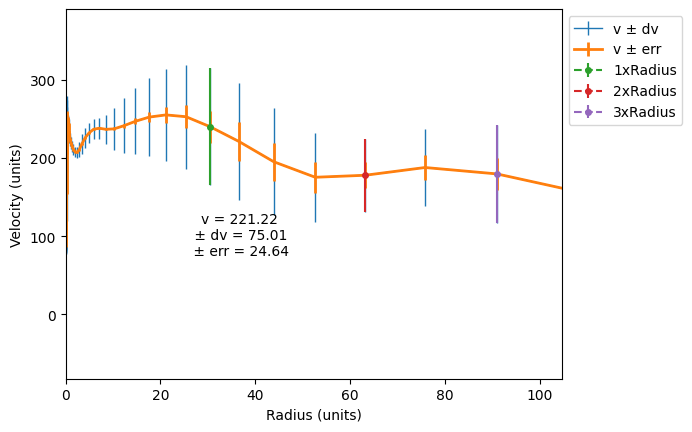

In [26]:
plotGal(mw, mwRds)

### Figure 2: Rotation curve of Milky Way galaxy with error bars for velocity (v) and two different uncertainties (dv and err). Colored error bars represent different radii multiples. This plot shows how the relative speed of the galaxy with respect to its center changes as a function of the radius. The purpose is to demonstrate that it does not follow the newtonian prediction exactly, thus suggesting dark matter. We analyze the newtonian prediction vs the measurements below with uncertainy considerations, and find the predictions and measurements consistent when considering either uncertainty.


In [27]:
vratios(mw, mwRds, 2)
vratios(mw, mwRds, 2, "err")

vratios(mw, mwRds, 3)
vratios(mw, mwRds, 3, "err")

--------------------
Error type: dv
Radius value: 2x
Expected velocity ratio: 1.44 +/- 0.04
Actual velocity ratio: 1.35 +/- 0.55
Expected range: 1.36 - 1.52
2-sigma upper bound (2-sigma): 2.45
2-sigma lower bound (2-sigma): 0.25
Expected vs measured ratios are consistent at 2-sigma significance
--------------------
--------------------
Error type: err
Radius value: 2x
Expected velocity ratio: 1.44 +/- 0.04
Actual velocity ratio: 1.35 +/- 0.17
Expected range: 1.36 - 1.52
2-sigma upper bound (2-sigma): 1.69
2-sigma lower bound (2-sigma): 1.01
Expected vs measured ratios are consistent at 2-sigma significance
--------------------
--------------------
Error type: dv
Radius value: 3x
Expected velocity ratio: 1.73 +/- 0.03
Actual velocity ratio: 1.34 +/- 0.62
Expected range: 1.67 - 1.78
2-sigma upper bound (2-sigma): 2.59
2-sigma lower bound (2-sigma): 0.09
Expected vs measured ratios are consistent at 2-sigma significance
--------------------
--------------------
Error type: err
Radius valu

Here we see that the expected and measured ratios are consistent with a 2 sigma confidence interval at 2 and 3 times the radius using the uncertainties in the comparison. This is an interesting result because for Andromeda the ratios were only consistent when using the first error, dv, and not the second one, while for the Milky Way, the comparison is consistent with either error!